In [1]:
# Load the packages
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Libraries for missing values:
import missingno as msno   
# !pip install fancyimpute --target=/kaggle/working/
#import fancyimpute
warnings.filterwarnings("ignore")





In [2]:
# 2. Create interactive widgets in Jupyter notebooks
# Use Jupyter Widges Package - https://ipywidgets.readthedocs.io/en/stable/index.html 
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

# Configure pandas
pd.set_option('display.max_colwidth', None) # do not truncate column values
pd.set_option('display.max_rows', 200)      # max number of rows to display 
pd.set_option('display.max_columns', 300)   # max number of columns to display 

In [3]:
# Load the data
df_train = pd.read_csv("../datasets/train_new.csv", index_col='id')
df_test = pd.read_csv("../datasets/test_new.csv", index_col='id')

# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)[:-1]

target_feature = 'price'

df_train.head()


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,cylinder_layout,valves,aspiration,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford,375.0,3.5,NaN,NaN,NaN,NaN,10.0,Automatic,blue,grey
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.0,3.0,6.0,Cylinder,NaN,NaN,6.0,Manual,black,black
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other,300.0,4.2,8.0,Cylinder,NaN,NaN,6.0,Automatic,others,brown
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.0,3.0,6.0,Cylinder,NaN,NaN,NaN,AM,grey,brown
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.0,3.8,NaN,NaN,NaN,NaN,NaN,Automatic,white,black


In [4]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 24)
Shape of testing set: (36183, 23)


In [5]:

# price = target feature
df_train.describe()

,model_year,milage,price,brand_category,power_output,engine_size,cylinders,valves,speed
count,54273.000000,54273.000000,5.427300e+04,54273.000000,50216.000000,53667.000000,34122.000000,3535.000000,29409.000000
mean,2015.091979,72746.175667,3.921844e+04,1.985333,331.698323,3.716928,6.414542,21.816124,7.107042
std,5.588909,50469.490448,7.282634e+04,0.944259,108.053342,1.336200,1.853515,7.176576,1.505826
min,1974.000000,100.000000,2.000000e+03,1.000000,76.000000,0.650000,3.000000,12.000000,1.000000
25%,2012.000000,32268.000000,1.550000e+04,1.000000,255.000000,3.000000,4.000000,16.000000,6.000000
50%,2016.000000,66107.000000,2.800000e+04,2.000000,310.000000,3.500000,6.000000,24.000000,7.000000
75%,2019.000000,102000.000000,4.500000e+04,3.000000,400.000000,4.600000,8.000000,24.000000,8.000000
max,2024.000000,405000.000000,2.954083e+06,3.000000,1020.000000,8.400000,12.000000,64.000000,10.000000


In [6]:
# describe cat features

# clean_title: redundant feature since only one value present

df_train.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,cylinder_layout,aspiration,transmission_type,ext_color_basic,int_color_basic
count,54273,54273,54273,54273,54273,54273,54273,54273,54273,54273,34122,1896,54273,54273,54273
unique,53,1827,6,1061,46,260,124,2,1,14,1,2,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,other,Cylinder,Turbo,Automatic,black,black
freq,7369,780,49439,1452,16757,15078,31820,39896,54273,12431,34122,1868,42184,15742,32734


In [7]:
df_test.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,cylinder_layout,aspiration,transmission_type,ext_color_basic,int_color_basic
count,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,22902,1203,36183,36183,36183
unique,53,1791,6,1038,44,230,111,2,1,14,1,2,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,other,Cylinder,Turbo,Automatic,black,black
freq,4854,496,33033,886,11273,10027,21122,26598,36183,8261,22902,1179,28052,10443,21710


In [8]:
# check for duplicates
num_duplicates = df_train.duplicated().sum()

if num_duplicates !=0:
    print(f'There are {num_duplicates} duplicate rows, removing them from the data.')
    df_train.drop_duplicates(inplace=True)
else:
    print(f'{num_duplicates} duplicate rows detected.')

0 duplicate rows detected.


In [9]:
# check for missing values
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

                 Missing Values  Percentage
aspiration                52377   96.506550
valves                    50738   93.486632
speed                     24864   45.812835
cylinders                 20151   37.128959
cylinder_layout           20151   37.128959
power_output               4057    7.475172
engine_size                 606    1.116577


### Dropping columns 

modified columns: engine, transmission, ext_col, int_col, 

missing values: aspiration, valves, cylinder_layout, 

redundunt: clean_title , 



In [10]:
## drop columns
col_to_drop = [ 'engine', 'transmission', 'ext_col', 'int_col', 'brand',
               'aspiration', 'valves', 'cylinder_layout', 
               'clean_title', 'model']

df_train.drop(columns=col_to_drop, axis=1, inplace=True)
df_test.drop(columns=col_to_drop, axis=1, inplace=True)

df_train.head()

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,
0,2018,74349,Gasoline,None reported,11000,1,Ford,375.0,3.5,NaN,10.0,Automatic,blue,grey
1,2007,80000,Gasoline,None reported,8250,3,BMW,300.0,3.0,6.0,6.0,Manual,black,black
2,2009,91491,Gasoline,None reported,15000,3,other,300.0,4.2,8.0,6.0,Automatic,others,brown
3,2022,2437,Hybrid,None reported,63500,3,BMW,335.0,3.0,6.0,NaN,AM,grey,brown
4,2001,111000,Gasoline,None reported,7850,1,other,200.0,3.8,NaN,NaN,Automatic,white,black


In [11]:
# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)[:-1]
numerical_features.remove('price')
target_feature = 'price'


# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 14)
Shape of testing set: (36183, 13)


In [12]:
# Plotting the categorical variables in training and testing sets: ordered
# Define the function to plot the categorical variables
def count_plot(var, dataframe1, dataframe2):
    # Concatenate the two dataframes for the variable
    combined_data = pd.concat([dataframe1[var], dataframe2[var]]).dropna()
    
    # Determine the order of categories based on frequency
    category_order = combined_data.value_counts().index
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
    
    # Plot training data
    sns.countplot(y=var, data=dataframe1, ax=axes[0], order=category_order)
    axes[0].set_title(f'Training Set - {var}')
    
    # Plot testing data
    sns.countplot(y=var, data=dataframe2, ax=axes[1], order=category_order)
    axes[1].set_title(f'Testing Set - {var}')
    
    plt.tight_layout()
    plt.show()

# Define a function for interactive plotting
def inter_cat_plot(x):
    return count_plot(x, df_train, df_test)


# Create a dropdown widget for selecting the categorical variable
widget_cat_plot = widgets.Dropdown(
    options=categorical_features,
    description="Categorical Variable:", 
    style=style
)

# Use interact to create an interactive plot
interact(inter_cat_plot, x=widget_cat_plot)

interactive(children=(Dropdown(description='Categorical Variable:', options=('fuel_type', 'accident', 'top_bra…

<function __main__.inter_cat_plot(x)>

In [13]:
# Plot numerical variables:

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()

def inter_num_plot(x):
    return histogram_plot(x, df_train, df_test)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

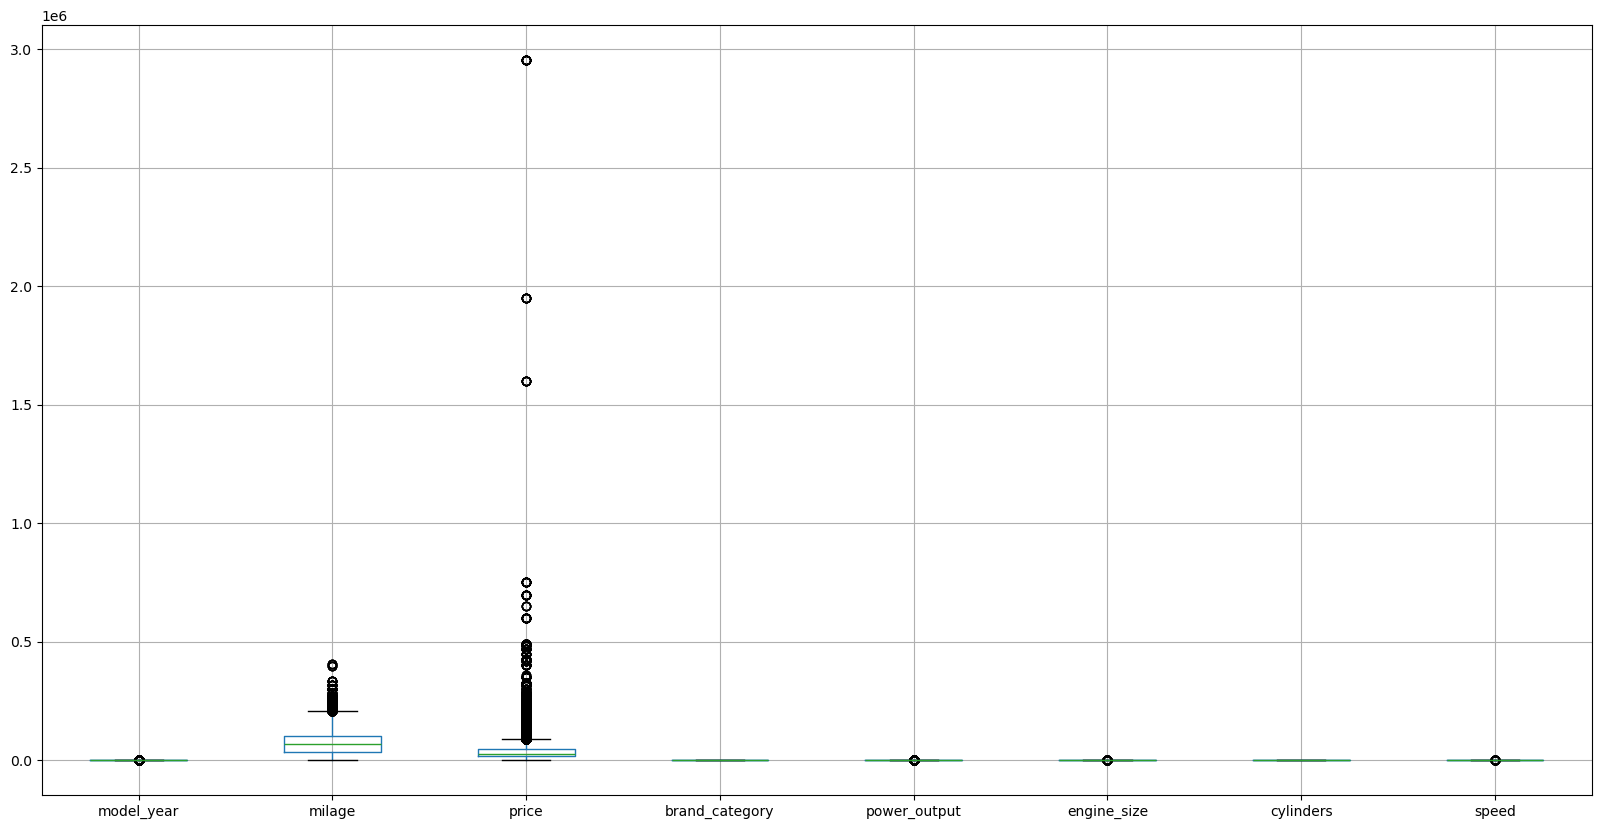

In [14]:
# identify outliers
df_train.boxplot(figsize=(20, 10))
plt.show()

<Axes: >

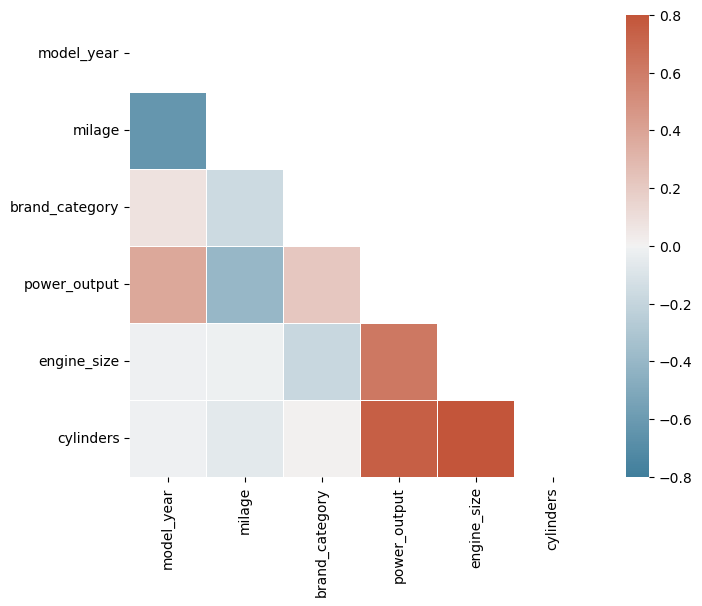

In [15]:
# Calculate correlation matrix 
# Check parameters: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html 
corr = df_train[numerical_features].corr() # method='pearson', 'kendall' , 'spearman'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.8,vmax=0.8, square=True, linewidths=.5)

## Feature engineering



### Missing values to deal with:

speed: 46%

cylinders: 37%

power output: 7%

engine_size: 1%


Can we get this information based on the {brand , model, model_year, fuel_type, transmission_type , power_output}. 



model: too many unique values @ 1827


In [16]:
# impute the missing values:

# Combine train and test datasets to ensure consistency in imputation
#df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Convert numeric columns to appropriate numeric types
columns_to_impute = ['speed', 'cylinders', 'power_output', 'engine_size']
#group_col = ['brand', 'model', 'transmission_type',  'model_year' ] #, 'fuel_type'

# Calculate the mean of columns_to_impute by grouping using group_col
#imputation_means = df_combined.groupby(group_col)[columns_to_impute].mean()

# Filling speed column with mean of Count column
#df_train.fillna(dataframe['speed'].mean(), inplace = True)

# Calculate mean for each column in df_train
impute_values = df_train[columns_to_impute].mean()


# Impute missing values in df_train
df_train_imputed  = df_train.fillna(impute_values, inplace=False)

# Impute missing values in df_test using the same impute_values
df_test_imputed = df_test.fillna(impute_values, inplace=False)



#df_train.groupby(group_col)['speed'].transform(lambda x: x.fillna(x.mean()))


In [18]:
# Plot numerical variables: imputed data

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()

def inter_num_plot(x):
    return histogram_plot(x, df_train_imputed, df_test_imputed)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

In [19]:

df = check_missing_values(df_test_imputed)
print(df.sort_values(by='Missing Values', ascending=False))

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [20]:
df_train_imputed

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,
0,2018,74349,Gasoline,None reported,11000,1,Ford,375.000000,3.5,6.414542,10.000000,Automatic,blue,grey
1,2007,80000,Gasoline,None reported,8250,3,BMW,300.000000,3.0,6.000000,6.000000,Manual,black,black
2,2009,91491,Gasoline,None reported,15000,3,other,300.000000,4.2,8.000000,6.000000,Automatic,others,brown
3,2022,2437,Hybrid,None reported,63500,3,BMW,335.000000,3.0,6.000000,7.107042,AM,grey,brown
4,2001,111000,Gasoline,None reported,7850,1,other,200.000000,3.8,6.414542,7.107042,Automatic,white,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,2017,29000,Gasoline,None reported,29000,3,BMW,445.000000,4.4,8.000000,8.000000,Automatic,white,brown
54269,2015,94634,E85 Flex Fuel,At least 1 accident or damage reported,6500,3,Audi,220.000000,2.0,4.000000,6.000000,Automatic,black,black
54270,2013,40989,Gasoline,At least 1 accident or damage reported,18950,3,Porsche,420.000000,3.6,6.414542,7.107042,AM,white,black


In [21]:
# Spliting the dataset.
Y = np.log(df_train_imputed[target_feature]) # transform the price to log(price)
X = df_train_imputed.drop(columns=[target_feature])

X_train, X_val,y_train,y_val = train_test_split(X, Y, test_size=0.20, random_state=5)

Cat: ['brand',
 'fuel_type',
 'accident',
 'brand_category',
 'transmission_type',
 'ext_color_basic',
 'int_color_basic']


 Num: ['model_year', 'milage', 'power_output', 'engine_size', 'cylinders']

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

## create ranking among all features by selecting only one
#rfe = RFE(LinearRegression(), n_features_to_select=1)
#rfe.fit(X.select_dtypes(include=['float64', 'int64']), Y)
#rfe.ranking_

######
one_hot_features = ['top_brand', 'fuel_type','transmission_type', 'ext_color_basic','int_color_basic' ,
                    #'brand_category'
                    ] 
#label_encode_features = ['brand_category'] 
dummy_encode_features = ['accident'] 

# Define the preprocessing for each column type
preprocessor = ColumnTransformer(
    transformers=[
        # R2 with standard scaler: 0.60
        # Gaussian QT: 0.61
        #('num', QuantileTransformer(n_quantiles=100, output_distribution='normal'), numerical_features),
        # Uniform QT: 0.62
        ('num', QuantileTransformer(n_quantiles=100, output_distribution='uniform'), numerical_features),
        ('onehot', OneHotEncoder(), one_hot_features),
        ('dummy', FunctionTransformer(dummy_encode, validate=False), dummy_encode_features)
    ],
    remainder='passthrough'
)

#rfe_lr = RFE(estimator=LinearRegression(), n_features_to_select=25, step=1)
rfecv = RFECV(estimator=LinearRegression())
pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        #("scaler", MinMaxScaler()),
        #("rfe_lr", rfe_lr),
        ('Feature Selection', rfecv),
        ('regressor', LinearRegression())
    ]
)


n_scores = cross_val_score(pipe, X, Y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
print(np.mean(n_scores))

# Convert the negative mean squared error scores to positive values
mse_scores = -n_scores

# Compute the mean and standard deviation of the cross-validation scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")



-0.2580927842194799
Mean MSE: 0.2580927842194799
Standard Deviation of MSE: 0.0027495730320318133


In [82]:
print("Optimal number of features : %d” % rfecv.n_features_)

SyntaxError: unterminated string literal (detected at line 1) (2412260080.py, line 1)

In [67]:
# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Evaluate the performance of the model on the validation set
val_predictions = pipe.predict(X_val)
mse = mean_squared_error(y_val, val_predictions)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, val_predictions)

# Print the evaluation metrics
print(f"MSE on Validation Set: {mse}")
print(f"RMSE on Validation Set: {rmse}")
print(f"R-squared on Validation Set: {r2}")

MSE on Validation Set: 0.26231153704103843
RMSE on Validation Set: 0.5115970537858086
R-squared on Validation Set: 0.6227423758524031


### Feature selection with f_regression 

In [83]:
# get feature importance with RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import (
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler
)
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


one_hot_features = ['top_brand', 'fuel_type','transmission_type', 'ext_color_basic','int_color_basic' ,
                    #'brand_category'
                    ] 
#label_encode_features = ['brand_category'] 
dummy_encode_features = ['accident'] 

# Function for dummy encoding
def dummy_encode(df):
    return pd.get_dummies(df, drop_first=True)

# Define the preprocessing for each column type
preprocessor = ColumnTransformer(
    transformers=[
        # R2 with standard scaler: 0.60
        # Gaussian QT: 0.61
        #('num', QuantileTransformer(n_quantiles=100, output_distribution='normal'), numerical_features),
        # Uniform QT: 0.62
        ('num', QuantileTransformer(n_quantiles=100, output_distribution='uniform'), numerical_features),
        ('onehot', OneHotEncoder(), one_hot_features),
        ('dummy', FunctionTransformer(dummy_encode, validate=False), dummy_encode_features)
    ],
    remainder='passthrough'
)
'''
# Label encode separately as it needs to fit on the entire column
for col in label_encode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
   # df_test_imputed[col] = le.transform(df_test_imputed[col])
'''

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
    ('regressor', LinearRegression())
    #('ridge_regressor', RidgeCV())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

NameError: name 'adj_r2' is not defined

In [37]:
# Extracting feature importance
ridge_model = pipeline.named_steps['ridge_regressor']
coefficients = ridge_model.coef_

# Get the feature names from the preprocessor
preprocessor = pipeline.named_steps['preprocessor']
# This returns a list of arrays of feature names
feature_names = preprocessor.transformers_[0][1].get_feature_names_out(numerical_features).tolist()
feature_names += preprocessor.transformers_[1][1].get_feature_names_out(one_hot_features).tolist()
# dummy_encode does not provide feature names directly, so infer them
for feature in dummy_encode_features:
    feature_names += [f"{feature}_{cat}" for cat in dummy_encode(X_train[[feature]]).columns]

# Assuming remainder='passthrough', add those features' names directly
if preprocessor.remainder == 'passthrough':
    passthrough_features = [f for f in X_train.columns if f not in numerical_features + one_hot_features + dummy_encode_features]
    feature_names += passthrough_features

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

importance_df = importance_df.sort_values(by='Coefficient', ascending=False)
print(importance_df)



                            Feature  Coefficient
0                        model_year     1.057636
2                      power_output     0.629985
3                       engine_size     0.320931
19                 fuel_type_Diesel     0.184065
46            brand_category_Luxury     0.176301
29        transmission_type_Unknown     0.147050
12                   top_brand_Land     0.135387
17                 top_brand_Toyota     0.128453
11                   top_brand_Jeep     0.099061
49  accident_accident_None reported     0.086542
9                    top_brand_Ford     0.077249
16                top_brand_Porsche     0.069945
45            int_color_basic_white     0.067625
10                    top_brand_GMC     0.058895
20          fuel_type_E85 Flex Fuel     0.027148
44           int_color_basic_silver     0.024236
33             ext_color_basic_grey     0.023698
43              int_color_basic_red     0.023386
34           ext_color_basic_others     0.017882
15                 t

**Neither hyperparameter tuning (during the base model fitting) nor the feature selection (using f_regression and RFECV) helped improve the RMSe and R^2. Given that the model performance hasn't improved using these two methods and that the resudual plots demonstrate lack of normality, we will employ iterative re-weighted regression to identify of this would improve our results.**

In [ ]:
# weighted least squares
import statsmodels.api as sm


# Calculate weights based on the inverse of the variance of the errors
errors = Y - np.mean(Y)
error_variance = np.var(errors)
weights = 1 / error_variance

# Fit weighted least squares regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=weights)
results = model.fit()

# Print regression results
print(results.summary())


In [ ]:
y_test_pred = pipeline.predict(df_test_imputed)
y_test_pred

y_hat_data = df_test_imputed.copy(deep = True)
y_hat_data['price_lm'] = np.exp( y_test_pred)

array([10.12142465,  9.84508459, 10.22973242, ...,  9.41307818,
       10.74652441,  9.41695898])

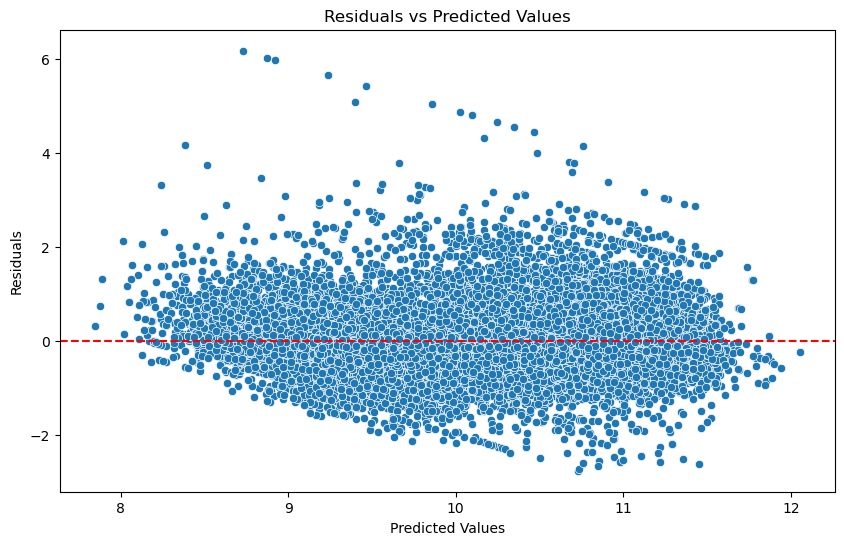

In [135]:
# residual analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the training set to analyze residuals
y_train_pred = pipeline.predict(X_train)

# Residuals
residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()


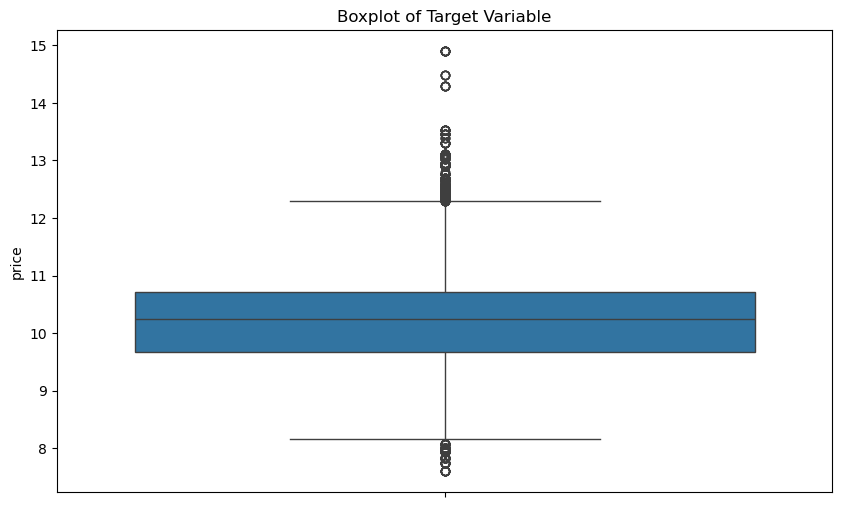

In [136]:
# outliers:
# Box plot to identify outliers in target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Target Variable')
plt.show()


In [137]:
# model complexity

# Calculate training RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Print train and validation scores
print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {rmse}')
print(f'Training R-squared: {r2_score(y_train, y_train_pred)}')
print(f'Validation R-squared: {r2}')


Training RMSE: 0.5158366225639277
Validation RMSE: 0.5212858145209542
Training R-squared: 0.6094004970505325
Validation R-squared: 0.6091838997337604


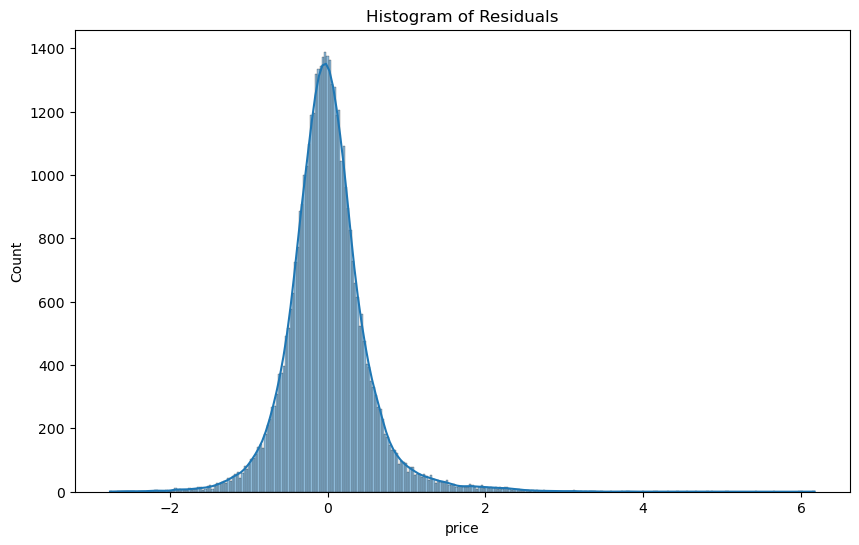

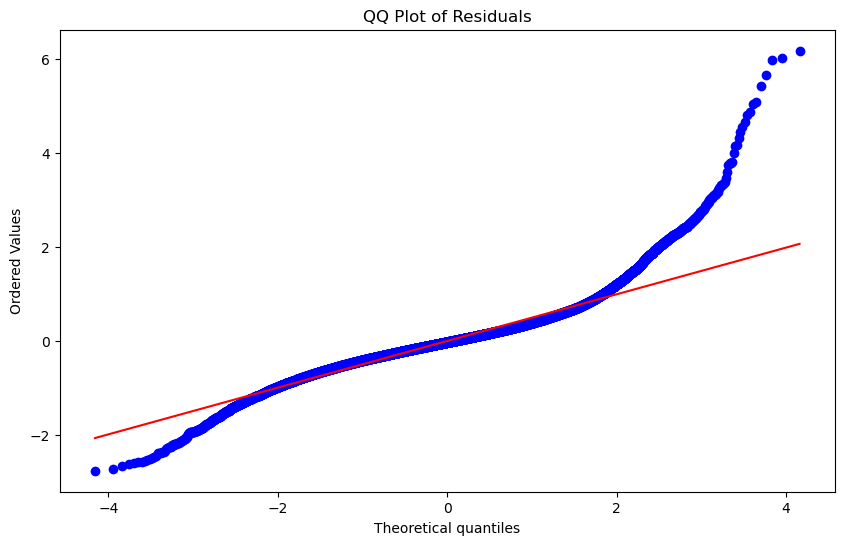

In [138]:
# Check normality of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# QQ plot
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()


In [184]:
# Train and save multiple models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
import joblib


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, model in models.items():
    model.fit(preprocessor.transform(X_train), y_train)
    y_pred = model.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_model_name = name

# Save the best model
joblib.dump(best_model, 'best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")


Linear Regression R^2 score: 0.6092986868112154
Random Forest R^2 score: 0.6301525381838693
XGBoost R^2 score: 0.6473689766084514


KeyboardInterrupt: 

## Hyperparameter Tuning

In [140]:
from sklearn.model_selection import RandomizedSearchCV

# Define the models and hyperparameter grids
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
    })
    # SVR is too heavy for tuning...
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, (model, param_grid) in models.items():
    if param_grid:
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        search.fit(preprocessor.transform(X_train), y_train)
        best_model_for_name = search.best_estimator_
    else:
        best_model_for_name = model
        best_model_for_name.fit(preprocessor.transform(X_train), y_train)
    
    y_pred = best_model_for_name.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = best_model_for_name
        best_model_name = name

# Save the best model and its name
joblib.dump(best_model, 'hypertuned_best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")



Linear Regression R^2 score: 0.6091838997337604
Random Forest R^2 score: 0.646582602587013
XGBoost R^2 score: 0.6481680302276254
Best model: XGBoost with R^2 score: 0.6481680302276254


In [188]:
# Load the test data, make predictions, and save the results
df_test_imputed_transformed = preprocessor.transform(df_test_imputed)
predictions = best_model.predict(df_test_imputed_transformed)
results = pd.DataFrame({
    'price': predictions
})

# Save results to a CSV file
#results.to_csv('../datasets/predictions.csv', index=False)
#print("Predictions saved to predictions.csv")

In [193]:
results
y_hat_data['price_xgb'] = np.exp(predictions)
y_hat_data
#df_train_imputed[df_train_imputed['brand']=='Saab']

,model_year,milage,fuel_type,accident,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,price_lm,price_xgb
id,,,,,,,,,,,,,,,
54273,2014,73000,Gasoline,None reported,Luxury,Mercedes-Benz,302.0,3.5,6.414542,7.107042,Automatic,white,brown,24870.176897,20715.386719
54274,2015,128032,Gasoline,None reported,Luxury,Lexus,275.0,3.5,6.414542,8.000000,Automatic,silver,black,18865.395392,18748.412109
54275,2015,51983,Gasoline,None reported,Luxury,Mercedes-Benz,241.0,2.0,4.000000,7.000000,Automatic,blue,white,27715.093019,23397.394531
54276,2018,29500,Gasoline,At least 1 accident or damage reported,Premium,Land,518.0,5.0,8.000000,7.107042,AM,white,white,56927.975788,45581.785156
54277,2020,90000,Gasoline,At least 1 accident or damage reported,Luxury,BMW,335.0,3.0,6.000000,8.000000,Automatic,white,black,28863.545460,31538.039062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90451,2019,4500,Gasoline,None reported,Regular,GMC,420.0,6.2,8.000000,10.000000,Automatic,grey,black,63713.509354,57855.125000
90452,2004,185000,Gasoline,At least 1 accident or damage reported,Regular,Chevrolet,295.0,5.3,8.000000,4.000000,Automatic,red,grey,6536.129901,9213.522461
90453,2011,116000,Gasoline,None reported,Regular,Toyota,132.0,1.8,4.000000,5.000000,Manual,brown,grey,12247.513043,9712.653320


In [194]:
# add 'ensemble'
y_hat_data['price_mix'] = (y_hat_data['price_lm'] + y_hat_data['price_xgb'])/2
y_hat_data

,model_year,milage,fuel_type,accident,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,price_lm,price_xgb,price_mix
id,,,,,,,,,,,,,,,,
54273,2014,73000,Gasoline,None reported,Luxury,Mercedes-Benz,302.0,3.5,6.414542,7.107042,Automatic,white,brown,24870.176897,20715.386719,22792.781808
54274,2015,128032,Gasoline,None reported,Luxury,Lexus,275.0,3.5,6.414542,8.000000,Automatic,silver,black,18865.395392,18748.412109,18806.903751
54275,2015,51983,Gasoline,None reported,Luxury,Mercedes-Benz,241.0,2.0,4.000000,7.000000,Automatic,blue,white,27715.093019,23397.394531,25556.243775
54276,2018,29500,Gasoline,At least 1 accident or damage reported,Premium,Land,518.0,5.0,8.000000,7.107042,AM,white,white,56927.975788,45581.785156,51254.880472
54277,2020,90000,Gasoline,At least 1 accident or damage reported,Luxury,BMW,335.0,3.0,6.000000,8.000000,Automatic,white,black,28863.545460,31538.039062,30200.792261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90451,2019,4500,Gasoline,None reported,Regular,GMC,420.0,6.2,8.000000,10.000000,Automatic,grey,black,63713.509354,57855.125000,60784.317177
90452,2004,185000,Gasoline,At least 1 accident or damage reported,Regular,Chevrolet,295.0,5.3,8.000000,4.000000,Automatic,red,grey,6536.129901,9213.522461,7874.826181
90453,2011,116000,Gasoline,None reported,Regular,Toyota,132.0,1.8,4.000000,5.000000,Manual,brown,grey,12247.513043,9712.653320,10980.083182


id
54273    24870.176897
54274    18865.395392
54275    27715.093019
54276    56927.975788
54277    28863.545460
             ...     
90451    63713.509354
90452     6536.129901
90453    12247.513043
90454    46468.243007
90455    12295.135587
Name: price_lm, Length: 36183, dtype: float64

In [196]:
# saving the predictions to csv
y_hat_data['price_lm'].to_csv('../datasets/predictions_lm.csv')
y_hat_data['price_xgb'].to_csv('../datasets/predictions_xgb.csv')
y_hat_data['price_mix'].to_csv('../datasets/predictions_mix.csv')
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


In [1]:
y_hat_data

NameError: name 'y_hat_data' is not defined

Sources:

https://www.kaggle.com/competitions/kagglex-cohort4/overview

https://www.kaggle.com/code/saadatkhalid/laptop-price-prediction-eda-model-app

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

https://arize.com/blog-course/



